In [2]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

from sympy.utilities.autowrap import autowrap

import vtk
from vtk.util import numpy_support

import pyevtk

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mpc
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

from numba import njit

mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['text.usetex'] = False
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.color'] = "#cdcdcd"
mpl.rcParams['grid.linestyle'] = ":"
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["#767afe", "#2b926a", "#b53546", "#e78b50", "#b462be"]) 
mpl.rcParams['font.family'] = 'cmr10'
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['axes.formatter.use_mathtext'] = True

from astropy import constants, units

from scipy.integrate import quad, solve_ivp
from scipy.optimize import fsolve

from time import time

%matplotlib widget

# Exercise 3 - Numerical integration of the advection equation on a 3D grid

Grid parameters definition



In [3]:
N = 50
L = 1

Delta_l = L/N

Definition of the partial derivatives using the provided stencil

In [4]:

c_int = np.array([1/12, -2/3, 0, 2/3, -1/12])
c_bo_f = np.array([-25/12, 4, -3, 4/3, -1/4])
c_bo_b = -np.flip(c_bo_f)
c_bint_f = np.array([-1/4, -5/6, 3/2, -1/2, 1/12])
c_bint_b = -np.flip(c_bint_f)


@njit
def partial_x(phi, i, j, k):
    if i == 0:
        c = c_bo_f
        dphi = phi[i:i+5, j, k]
    elif i == N-1:
        c = c_bo_b
        dphi = phi[i-4:, j, k]
    elif i == 1:
        c = c_bint_f
        dphi = phi[i-1:i+4, j, k]
    elif i == N-2:
        c = c_bint_b
        dphi = phi[i-3:, j, k]     
    else:
        c = c_int
        dphi = phi[i-2:i+3, j, k]
    
    return np.dot(c, dphi)/Delta_l

@njit
def partial_y(phi, i, j, k):
    if j == 0:
        c = c_bo_f
        dphi = phi[i, j:j+5, k]
    elif j == N-1:
        c = c_bo_b
        dphi = phi[i, j-4:, k]
    elif j == 1:
        c = c_bint_f
        dphi = phi[i,j-1:j+4, k]
    elif j == N-2:
        c = c_bint_b
        dphi = phi[i,j-3:, k]     
    else:
        c = c_int
        dphi = phi[i,j-2:j+3, k]
    
    return np.dot(c, dphi)/Delta_l

@njit
def partial_z(phi, i, j, k):
    if k == 0:
        c = c_bo_f
        dphi = phi[i,j,k:k+5]
    elif k == N-1:
        c = c_bo_b
        dphi = phi[i,j,k-4:]
    elif k == 1:
        c = c_bint_f
        dphi = phi[i,j,k-1:k+4]
    elif k == N-2:
        c = c_bint_b
        dphi = phi[i,j,k-3:]
    else:
        c = c_int
        dphi = phi[i,j,k-2:k+3]
    
    return np.dot(c, dphi)/Delta_l

In [5]:
@njit
def Partial_x(Phi):
    partial_x_phi = np.zeros_like(Phi)
    for i in range(N):
        for j in range(N):
            for k in range(N):
                partial_x_phi[i, j, k] = partial_x(Phi, i, j, k)
    
    return partial_x_phi

@njit
def Partial_y(Phi):
    partial_y_phi = np.zeros_like(Phi)
    for i in range(N):
        for j in range(N):
            for k in range(N):
                partial_y_phi[i, j, k] = partial_y(Phi, i, j, k)
    
    return partial_y_phi

@njit
def Partial_z(Phi):
    partial_z_phi = np.zeros_like(Phi)
    for i in range(N):
        for j in range(N):
            for k in range(N):
                partial_z_phi[i, j, k] = partial_z(Phi, i, j, k)
    
    return partial_z_phi

Definition of the grid and of the initial data

In [6]:
x = np.linspace(0, L, N)
y = np.linspace(0, L, N)
z = np.linspace(0, L, N)

xx, yy, zz = np.meshgrid(x, y, z, indexing='xy')

x_c = L/2
y_c = L/2
z_c = L/2

sigma = 0.1

Phi_0 = np.exp(-((xx-x_c)**2+(yy-y_c)**2+(zz-z_c)**2)/sigma**2)

State updater

In [7]:
v = [0.5, 0.25, 0.1]

def update_state(t, state):
    
    Phi = np.reshape(state, (N, N, N))
    
    dxPhi = Partial_x(Phi)
    dyPhi = Partial_y(Phi)
    dzPhi = Partial_z(Phi)
    
    dtPhi = -(v[0]*dxPhi+v[1]*dyPhi+v[2]*dzPhi)
    
    # Boundary conditions
    
    dtPhi[0, :, :] = -v[1]*dyPhi[0, :, :]-v[2]*dzPhi[0, :, :]
    dtPhi[:, 0, :] = -v[0]*dxPhi[:, 0, :]-v[2]*dzPhi[:, 0, :]
    dtPhi[:, :, 0] = -v[0]*dxPhi[:, :, 0]-v[1]*dyPhi[:, :, 0] 
    
    return dtPhi.flatten()

Actual integration using Runge-Kutta and setting a maximum step

In [8]:
Phi_sol = solve_ivp(update_state, (0, 3), Phi_0.flatten(), max_step = 0.5*Delta_l/np.max(v))

/var/folders/nc/r976xvfd307_rr033_4j2cz00000gn/T/ipykernel_68156/949069483.py:7: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 1, 'C', True, aligned=True), Array(float64, 1, 'A', False, aligned=True))
  partial_x_phi[i, j, k] = partial_x(Phi, i, j, k)


Exporting to VTK

In [10]:
from pyevtk.hl import pointsToVTK, gridToVTK

In [11]:
x_grid = np.linspace(0, L, N+1)
y_grid = np.linspace(0, L, N+1)
z_grid = np.linspace(0, L, N+1)


In [12]:
for i, t in enumerate(Phi_sol.t/10):
    gridToVTK(f"./vtk/frames/advection_{t:4f}", x_grid, y_grid, z_grid, cellData = {'advection': Phi_sol.y[:, i]})

# Results

### $y-z$ plane

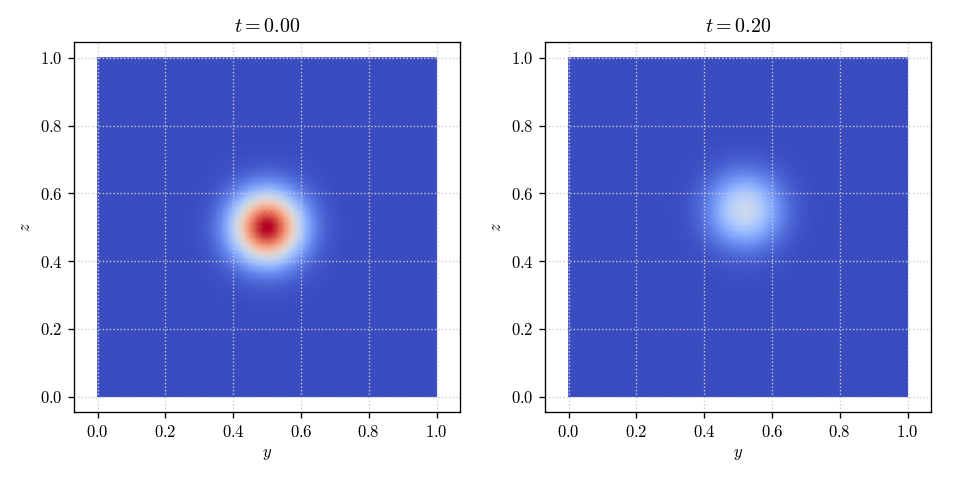

In [43]:
plt.close('all')

fig, axs = plt.subplots(1, 2, figsize= (8,4))

t_arr = [0, 10]

cmap = plt.get_cmap('coolwarm')

norm = mpl.colors.Normalize(vmin=np.min(Phi_0), vmax=np.max(Phi_0))
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

for t, ax in zip(t_arr, axs):

    ax.pcolormesh(x, y, Phi_sol.y[:,t].reshape((N,N,N))[N//2, :, :], cmap = cmap, norm = norm, shading = 'gouraud')

    ax.set_xlabel(r'$y$')
    ax.set_ylabel(r'$z$')
    
    ax.axis('equal')
    
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    
    ax.set_title(fr'$t={Phi_sol.t[t]:.2f}$')

fig.tight_layout()

### $x-y$ plane

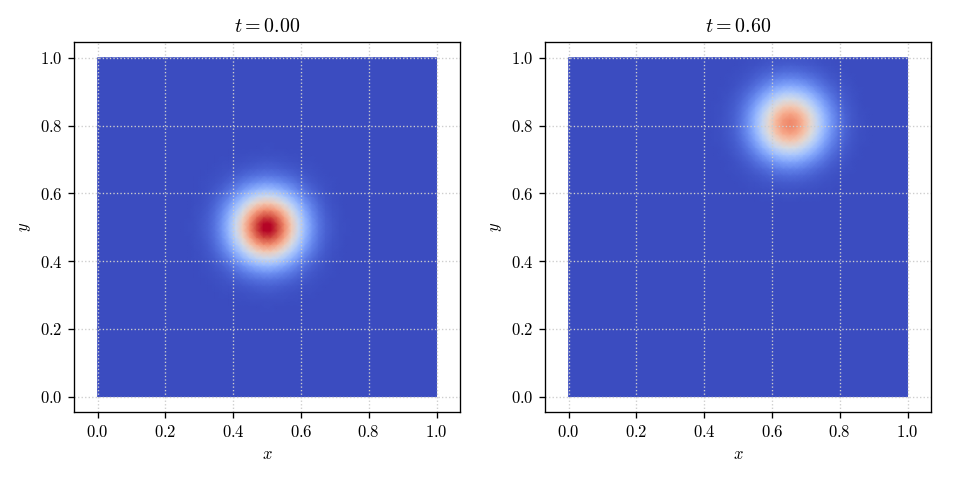

In [41]:
plt.close('all')

fig, axs = plt.subplots(1, 2, figsize= (8,4))

t_arr = [0, 30]

cmap = plt.get_cmap('coolwarm')

norm = mpl.colors.Normalize(vmin=np.min(Phi_0), vmax=np.max(Phi_0))
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

for t, ax in zip(t_arr, axs):

    ax.pcolormesh(x, y, Phi_sol.y[:,t].reshape((N,N,N))[:, :, N//2], cmap = cmap, norm = norm, shading = 'gouraud')

    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    
    ax.axis('equal')
    
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    
    ax.set_title(fr'$t={Phi_sol.t[t]:.2f}$')

fig.tight_layout()

### $x-z$ plane

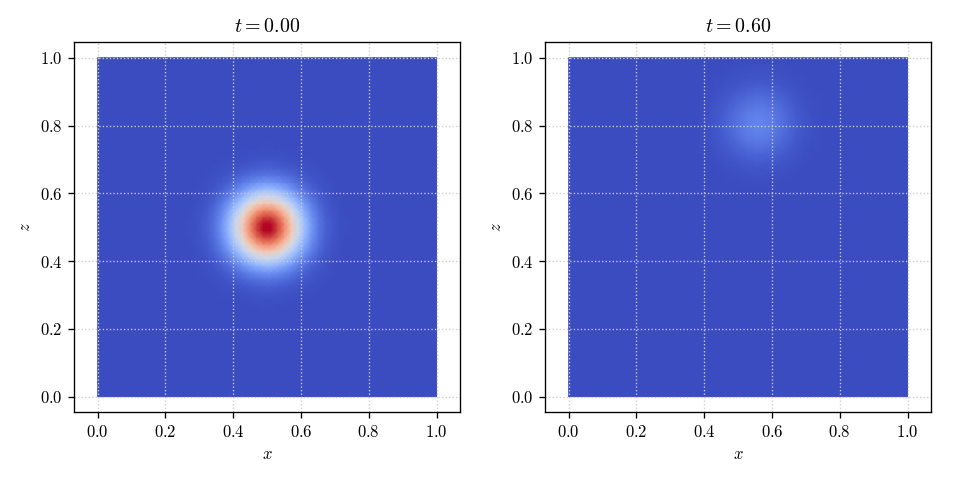

In [45]:
plt.close('all')

fig, axs = plt.subplots(1, 2, figsize= (8,4))

t_arr = [0, 30]

cmap = plt.get_cmap('coolwarm')

norm = mpl.colors.Normalize(vmin=np.min(Phi_0), vmax=np.max(Phi_0))
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

for t, ax in zip(t_arr, axs):

    ax.pcolormesh(x, y, Phi_sol.y[:,t].reshape((N,N,N))[:, N//2, :], cmap = cmap, norm = norm, shading = 'gouraud')

    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$z$')
    
    ax.axis('equal')
    
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    
    ax.set_title(fr'$t={Phi_sol.t[t]:.2f}$')

fig.tight_layout()

### Animations

Animations made in Paraview can be found in the 'animation_frames' directory.